# Constructing a Mini ChatGPT

In [2]:
import torch

from torch import nn
from matplotlib import pyplot as plt
from torch.nn import functional as F
from urllib.request import urlretrieve

In [3]:
# loading the accumulation of shakespeare's texts in raw format
local_filename, headers = urlretrieve("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

In [4]:
# loading the text from the above input.txt
with open(local_filename, 'r', encoding='utf-8') as f:
    text = f.read()
print(f"length of input.txt in chars: {len(text)}")
print(text[:1000])

length of input.txt in chars: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger f

In [5]:
# process the text and establish our vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"there are {vocab_size} chars in our vocab")
print(' '.join(chars)[::-1])

there are 65 chars in our vocab
z y x w v u t s r q p o n m l k j i h g f e d c b a Z Y X W V U T S R Q P O N M L K J I H G F E D C B A ? ; : 3 . - , ' & $ !   



In [6]:
# creating a basic mapping f: chars -> [0, 64] as a rudimentary encoder; and vice-versa as a decoder
stoi = {char : i for i, char in enumerate(chars)}
itos = {i : char for i, char in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda i: ''.join([itos[j] for j in i])

# toy example for demonstration purposes
encoding = encode("testing")
print(encoding)
print(decode(encoding))

[58, 43, 57, 58, 47, 52, 45]
testing


In [7]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])   

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [8]:
# 90% 105 train test split
n = int(0.9 * len(data))

# train test split
train_data = data[:n]
test_data = data[n:]

In [9]:
# parameterize batching and context
batch_size = 4
block_size = 8

def get_batch(split):
    
    data = test_data if split == 'test' else train_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

for b in range(batch_size): # batch dimension

    print('------------------------------------------------------------------------')
    
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 1, 58, 53,  1, 58, 46, 43,  1],
        [58, 63, 11,  1, 52, 53, 58,  1],
        [52, 42, 43, 56,  1, 45, 39, 45],
        [51, 39, 63, 53, 56,  1, 53, 44]])
targets:
torch.Size([4, 8])
tensor([[58, 53,  1, 58, 46, 43,  1, 15],
        [63, 11,  1, 52, 53, 58,  1, 39],
        [42, 43, 56,  1, 45, 39, 45, 43],
        [39, 63, 53, 56,  1, 53, 44,  1]])
------------------------------------------------------------------------
when input is [1] the target: 58
when input is [1, 58] the target: 53
when input is [1, 58, 53] the target: 1
when input is [1, 58, 53, 1] the target: 58
when input is [1, 58, 53, 1, 58] the target: 46
when input is [1, 58, 53, 1, 58, 46] the target: 43
when input is [1, 58, 53, 1, 58, 46, 43] the target: 1
when input is [1, 58, 53, 1, 58, 46, 43, 1] the target: 15
------------------------------------------------------------------------
when input is [58] the target: 63
when input is [58, 63] the target: 11
when input is [58, 63

In [10]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        # create embedding lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)


    def forward(self, idx, targets=None): 
        logits = self.token_embedding_table(idx)
        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape, loss.item())

print(decode(m.generate(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65]) 4.797887802124023

NhipvV
XXk3b-UydztX$efk,  yw.nLBv.3w'PzlfkrSkDy?WjsUeljbpyXDxlDyo;W-KwdWPf&rhnezhCPCjiYvKgOZ?zCWA yn


In [11]:
# instantiating the optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [12]:
batch_size = 32
losses = []

for steps in range(10000):
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

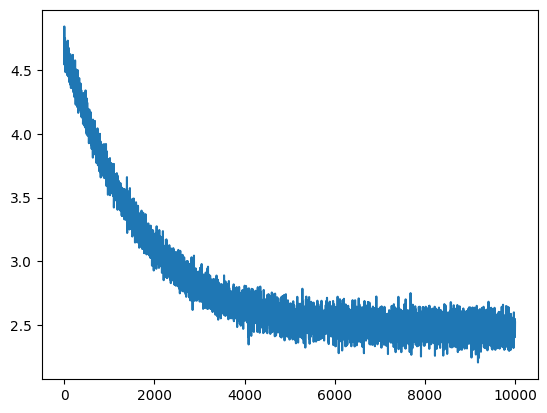

In [13]:
plt.plot(losses)

In [14]:
print(decode(m.generate(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


OFe pe w'swin mpenstorore itofist--Mand, mo.
Wootowis ELI the m poerr meab!
fin y thondou me buienon thither bicqCIFrikef hirduralle mothe t'dorde ad bure,-ayof onbe, iso erinth N haspr IOr is, osstourwinorat me'tllith ad CA the, ad:!

foweme ge t be; blinort vet fothay he sal anore ju we pke s me:
uiss lofumechutheenorabthereses
Worod od ace f ou. mpe canit w. 'doo leon the!
W: apindes igickntis wnsie anf?DO, tw
hant d NIOPlaner hise t facus ave cejume bapis s nsey?
Kipllllithod
Tor gemy:
t dak


# Building up to Self Attention

Note that the bottleneck in the bigram model's perform is because of it's limited context. The distribution of the next character is conditioned **only** on the distribution of the previous character, a prior that is too weak and does not contain enough information. Knowing the complexity of language, we know that it is a much more complex distribution and that we would require many more degrees of freedom, in this case letters of context, to accurately model it.

Now, consider the basic ways in which one might provide context for the previous characters as input to the model. The simplest and most naive form of context would be an average of the previous letters. This can be done naively using for loops or in a more efficient, vectorized format using matrices and broadcasting. We will demonstrate both of these methods and in the process, build up to self-attention.

## Setup

In [22]:
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

## Method 1: For Loops (Naive)

In [29]:
xbow = torch.zeros((B, T, C)) # bow = bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b,t] = torch.mean(xprev, 0)

## Method 2: Matrix Multiple for Weighted Aggregation

In [28]:
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x
torch.allclose(xbow, xbow2)

True

## Method 3: Using Softmax

In [18]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

## Method 4: Self Attention (Single-Head)

In [60]:
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B, T, C)

# single head of attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B x T x head_size)
q = query(x) # (B x T x head_size)
wei = q @ k.transpose(-2, -1) * (head_size ** -0.5) #  (B x T x 16) x (B x 16 x T) = (B x T x T)

tril = torch.tril(torch.ones(T,T)) # lower trianglular matrix of ones -- masking for masked attention
# wei = torch.zeros((T,T)) -- no longer need this because we are calculating wei from the data above
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out = wei @ x
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5041, 0.4959, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2786, 0.3312, 0.3901, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2122, 0.3152, 0.1767, 0.2959, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2212, 0.1544, 0.2248, 0.1813, 0.2183, 0.0000, 0.0000, 0.0000],
         [0.1427, 0.1249, 0.1321, 0.1791, 0.1689, 0.2523, 0.0000, 0.0000],
         [0.1660, 0.1760, 0.1220, 0.1390, 0.1466, 0.1382, 0.1121, 0.0000],
         [0.1049, 0.1649, 0.1653, 0.0965, 0.0976, 0.0701, 0.1112, 0.1894]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5569, 0.4431, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2703, 0.3612, 0.3685, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1655, 0.3096, 0.2028, 0.3222, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2457, 0.1198, 0.2599, 0.1721, 0.2025, 0.0000, 0.0000, 0.0000],
         [0.2271, 0.162

## Implementing a Self-Attention Head

In [74]:
class Head(nn.Module):

    def __init__(self, n_embed, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # computing self-attention scores
        wei = q @ k.transpose(-2, 1) * (C ** -0.5) # initialization scaling to even-out softmax activations
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # weighted aggregation based on attention scores
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        return out

## Implementing Multiheaded Self-Attention

In [81]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_embed, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, head_size) for _ in range(num_heads)])
    
    def forward(self, x):
        print(x.shape, self.heads[0](x).shape)
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [82]:
mha = MultiHeadAttention(32, 4, 8)
x = torch.randn(4, 8, 32)
x = mha(x)
x.shape

torch.Size([4, 8, 32]) torch.Size([4, 8, 8])


torch.Size([4, 8, 32])